### Import necessary libraries

In [1]:
import requests
import json
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
plt.style.use('fivethirtyeight') # For plots
sb.set()

### Extracting Data

Here, we extract the data we want to explore. <br>
1. **Bitcoin** <br>
2. **Dogecoin** <br>

In [2]:
api_key = '' # API KEY HERE
function = 'DIGITAL_CURRENCY_DAILY'
symbol = 'DOGE'
market = 'SGD'
url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&market={market}&apikey={api_key}'

response_Doge = requests.get(url)
response_Doge = response_Doge.json()

In [3]:
api_key = '' # API KEY HERE
function = 'DIGITAL_CURRENCY_DAILY'
symbol = 'BTC'
market = 'SGD'
url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&market={market}&apikey={api_key}'

response_BTC = requests.get(url)
response_BTC = response_BTC.json()

### Data Cleaning on Bitcoin & Dogecoin

In [4]:
BTC_resp = response_BTC['Time Series (Digital Currency Daily)']
BTC_resp = pd.DataFrame(BTC_resp)
BTC_resp = BTC_resp.T
BTC_resp.reset_index(level = 0, inplace=True)
BTC_resp.rename(columns={'index':'Date'}, inplace=True)

Doge_resp = response_Doge['Time Series (Digital Currency Daily)']
Doge_resp = pd.DataFrame(Doge_resp)
Doge_resp = Doge_resp.T
Doge_resp.reset_index(level = 0, inplace=True)
Doge_resp.rename(columns={'index':'Date'}, inplace=True)

In [5]:
BTC_resp.head()

,Date,1a. open (SGD),1b. open (USD),2a. high (SGD),2b. high (USD),3a. low (SGD),3b. low (USD),4a. close (SGD),4b. close (USD),5. volume,6. market cap (USD)
0,2022-01-30,51704.60460100,38166.83000000,51859.59582800,38281.24000000,51122.97770300,37737.49000000,51533.76338400,38040.72000000,3733.40203000,3733.40203000
1,2022-01-29,51094.63737900,37716.57000000,52454.98647800,38720.74000000,50487.55566800,37268.44000000,51704.61814800,38166.84000000,26129.49682000,26129.49682000
2,2022-01-28,50340.80101700,37160.11000000,51478.60000000,38000.00000000,48979.19204700,36155.01000000,51094.62383200,37716.56000000,42154.26956000,42154.26956000
3,2022-01-27,49862.76802800,36807.24000000,50441.53650900,37234.47000000,48101.34644700,35507.01000000,50340.78747000,37160.10000000,53020.87934000,53020.87934000
4,2022-01-26,50067.43610400,36958.32000000,52724.89690600,38919.98000000,49087.05326100,36234.63000000,49865.61289800,36809.34000000,69830.16036000,69830.16036000


In [6]:
Doge_resp.head()

,Date,1a. open (SGD),1b. open (USD),2a. high (SGD),2b. high (USD),3a. low (SGD),3b. low (USD),4a. close (SGD),4b. close (USD),5. volume,6. market cap (USD)
0,2022-01-30,0.19358663,0.14290000,0.19385757,0.14310000,0.19128364,0.14120000,0.19290928,0.14240000,61977948.00000000,61977948.00000000
1,2022-01-29,0.19169005,0.14150000,0.19534774,0.14420000,0.19006441,0.14030000,0.19372210,0.14300000,339117872.00000000,339117872.00000000
2,2022-01-28,0.19169005,0.14150000,0.19318022,0.14260000,0.18654219,0.13770000,0.19155458,0.14140000,464231063.00000000,464231063.00000000
3,2022-01-27,0.19385757,0.14310000,0.19765073,0.14590000,0.18451014,0.13620000,0.19155458,0.14140000,677890025.00000000,677890025.00000000
4,2022-01-26,0.19331569,0.14270000,0.20781098,0.15340000,0.19087723,0.14090000,0.19385757,0.14310000,1324673854.00000000,1324673854.00000000


We are not interested in the `Volume` and `Market Cap`. Therefore we drop them. <br>
Also, we drop all `USD` values as we want to base on `SGD` values.

In [7]:
BTC_resp = BTC_resp.drop(['5. volume', '6. market cap (USD)', '1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)'], axis=1)
Doge_resp = Doge_resp.drop(['5. volume', '6. market cap (USD)', '1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)'], axis=1)

In [8]:
BTC_resp.head()

,Date,1a. open (SGD),2a. high (SGD),3a. low (SGD),4a. close (SGD)
0,2022-01-30,51704.60460100,51859.59582800,51122.97770300,51533.76338400
1,2022-01-29,51094.63737900,52454.98647800,50487.55566800,51704.61814800
2,2022-01-28,50340.80101700,51478.60000000,48979.19204700,51094.62383200
3,2022-01-27,49862.76802800,50441.53650900,48101.34644700,50340.78747000
4,2022-01-26,50067.43610400,52724.89690600,49087.05326100,49865.61289800


In [9]:
Doge_resp.head()

,Date,1a. open (SGD),2a. high (SGD),3a. low (SGD),4a. close (SGD)
0,2022-01-30,0.19358663,0.19385757,0.19128364,0.19290928
1,2022-01-29,0.19169005,0.19534774,0.19006441,0.19372210
2,2022-01-28,0.19169005,0.19318022,0.18654219,0.19155458
3,2022-01-27,0.19385757,0.19765073,0.18451014,0.19155458
4,2022-01-26,0.19331569,0.20781098,0.19087723,0.19385757


We convert the Date column to a `datetime` format, and convert the rest of the columns to `float` as they are currently typed as an object.

In [10]:
for i in BTC_resp.columns[1:]:
    print(i)

1a. open (SGD)
2a. high (SGD)
3a. low (SGD)
4a. close (SGD)


In [11]:
BTC_resp.Date = pd.to_datetime(BTC_resp.Date, format = '%Y/%m/%d')
for colName in BTC_resp.columns[1:]:
    BTC_resp[str(colName)] = BTC_resp[str(colName)].astype(float)
    
Doge_resp.Date = pd.to_datetime(Doge_resp.Date, format = '%Y/%m/%d')
for colName in Doge_resp.columns[1:]:
    Doge_resp[str(colName)] = Doge_resp[str(colName)].astype(float)

In [12]:
BTC_resp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1000 non-null   datetime64[ns]
 1   1a. open (SGD)   1000 non-null   float64       
 2   2a. high (SGD)   1000 non-null   float64       
 3   3a. low (SGD)    1000 non-null   float64       
 4   4a. close (SGD)  1000 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 39.2 KB


In [13]:
Doge_resp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941 entries, 0 to 940
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             941 non-null    datetime64[ns]
 1   1a. open (SGD)   941 non-null    float64       
 2   2a. high (SGD)   941 non-null    float64       
 3   3a. low (SGD)    941 non-null    float64       
 4   4a. close (SGD)  941 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 36.9 KB


Now that we have the Data prepared in the formats we want, we can perfom some EDA on the Data.

In [14]:
def showPlot(df):
    plt.figure(figsize=(24,12))
    sb.lineplot(data=df, x=df['Date'], y=df['1a. open (SGD)'], label='Open')
    sb.lineplot(data=df, x=df['Date'], y=df['2a. high (SGD)'], label='High', color='g')
    sb.lineplot(data=df, x=df['Date'], y=df['3a. low (SGD)'], label='Low', color='orange')
    sb.lineplot(data=df, x=df['Date'], y=df['4a. close (SGD)'], label='Close', color='r')
    plt.xlabel("Date")
    plt.ylabel("Price")
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y"))
    plt.gcf().autofmt_xdate()
    plt.show()

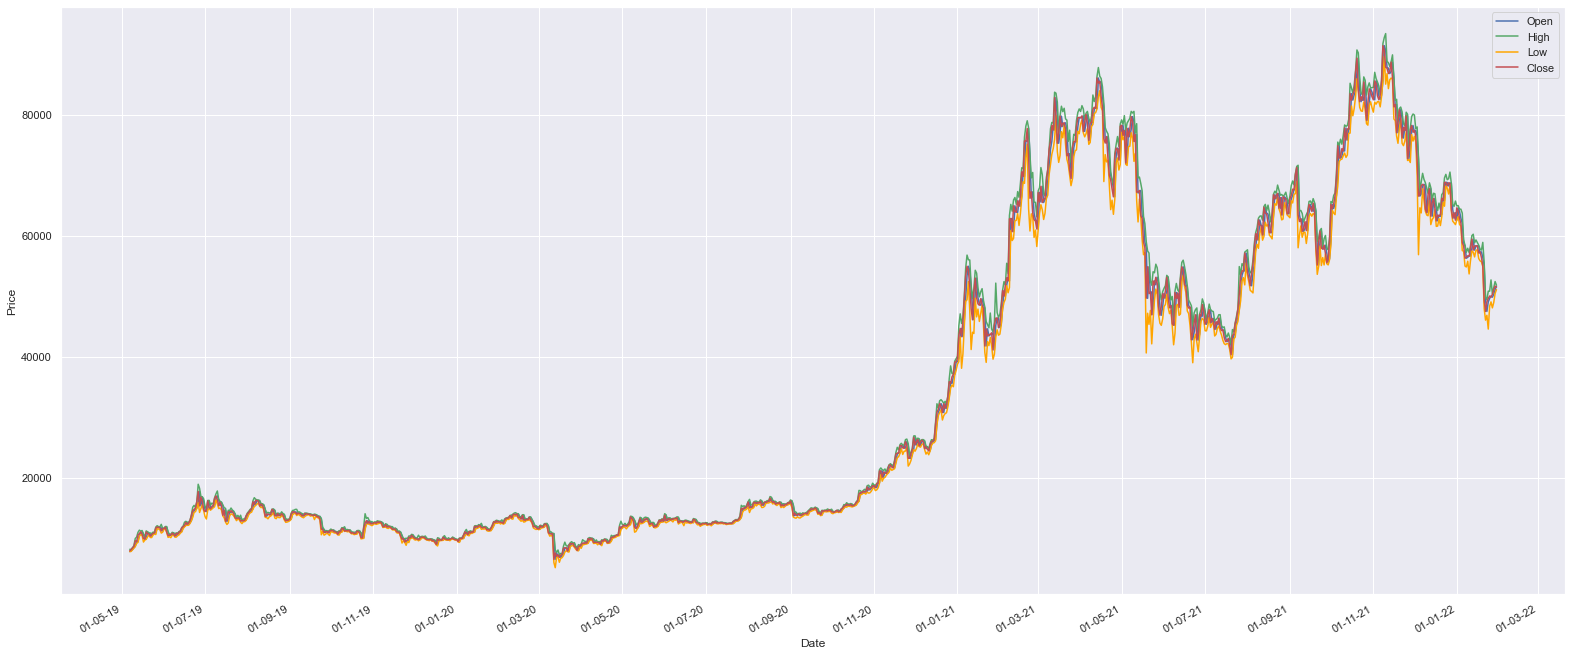

In [15]:
showPlot(BTC_resp)

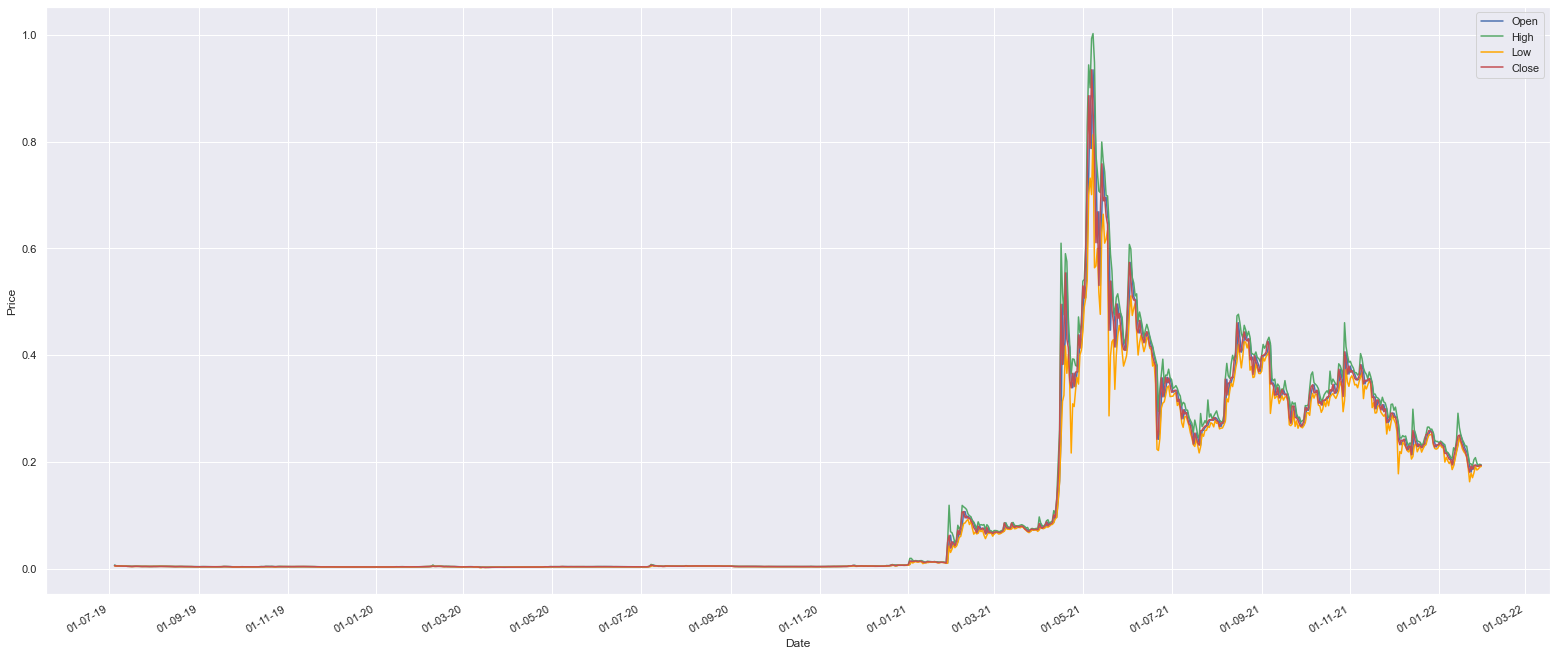

In [16]:
showPlot(Doge_resp)

In [17]:
BTC_resp.describe()

,1a. open (SGD),2a. high (SGD),3a. low (SGD),4a. close (SGD)
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,33503.773739,34476.336657,32398.639797,33547.694061
std,25894.651977,26631.956009,25012.623016,25888.322839
min,6502.573547,7268.534474,5123.651511,6502.560000
25%,12448.947915,12646.828944,12231.135862,12455.345486
50%,15780.649680,16079.611650,15272.379788,15790.701554
75%,58105.108276,59402.917650,56310.659109,58104.762828
max,91477.228354,93474.300000,89711.485280,91477.241901


In [18]:
Doge_resp.describe()

,1a. open (SGD),2a. high (SGD),3a. low (SGD),4a. close (SGD)
count,941.000000,941.000000,941.000000,941.000000
mean,0.116179,0.124033,0.108110,0.116372
std,0.170644,0.184018,0.156136,0.170616
min,0.002028,0.002226,0.001537,0.002143
25%,0.003435,0.003509,0.003362,0.003432
50%,0.004437,0.004559,0.004282,0.004437
75%,0.247233,0.261186,0.231898,0.247043
max,0.934499,1.002410,0.812820,0.934499


We want to see the correlation between Bitcoin and Dogecoin... <br>
We decided to stick with one variable which was the opening price. <br>
Hence we dropped all columns except for the Date and Open columns.

In [19]:
response_Doge = response_Doge['Time Series (Digital Currency Daily)']
df_Doge = pd.DataFrame(response_Doge)
df_Doge = df_Doge.T
df_Doge.reset_index(level = 0, inplace=True)

df_Doge = df_Doge.drop(['1b. open (USD)', '2a. high (SGD)', '2b. high (USD)', '3a. low (SGD)', '3b. low (USD)', '4a. close (SGD)', '4b. close (USD)', '5. volume', '6. market cap (USD)'], axis=1)
df_Doge.columns = ['Date' , 'Open (Doge)']
df_Doge.Date = pd.to_datetime(df_Doge.Date, format = '%Y/%m/%d')
df_Doge['Open (Doge)'] = df_Doge['Open (Doge)'].astype(float)

response_BTC = response_BTC['Time Series (Digital Currency Daily)']
df_BTC = pd.DataFrame(response_BTC)
df_BTC = df_BTC.T
df_BTC.reset_index(level = 0, inplace=True)

df_BTC = df_BTC.drop(['1b. open (USD)', '2a. high (SGD)', '2b. high (USD)', '3a. low (SGD)', '3b. low (USD)', '4a. close (SGD)', '4b. close (USD)', '5. volume', '6. market cap (USD)'], axis=1)
df_BTC.columns = ['Date', 'Open (BTC)']
df_BTC.Date = pd.to_datetime(df_BTC.Date, format = '%Y/%m/%d')
df_BTC['Open (BTC)'] = df_BTC['Open (BTC)'].astype(float)

In [20]:
df_BTC

,Date,Open (BTC)
0,2022-01-30,51704.604601
1,2022-01-29,51094.637379
2,2022-01-28,50340.801017
3,2022-01-27,49862.768028
4,2022-01-26,50067.436104
...,...,...
995,2019-05-11,8636.429252
996,2019-05-10,8412.619265
997,2019-05-09,8110.128302
998,2019-05-08,7920.036798


In [21]:
df_Doge

,Date,Open (Doge)
0,2022-01-30,0.193587
1,2022-01-29,0.191690
2,2022-01-28,0.191690
3,2022-01-27,0.193858
4,2022-01-26,0.193316
...,...,...
936,2019-07-09,0.004690
937,2019-07-08,0.004793
938,2019-07-07,0.004747
939,2019-07-06,0.005248


### Let's Concat BTC & Doge 

In [22]:
# Drop Doge Date col first
# Join both of them into one df
joint_df = pd.concat([df_BTC, df_Doge.drop(['Date'], axis=1)], axis=1)
joint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1000 non-null   datetime64[ns]
 1   Open (BTC)   1000 non-null   float64       
 2   Open (Doge)  941 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 23.6 KB


In [23]:
joint_df.isna().sum()

Date            0
Open (BTC)      0
Open (Doge)    59
dtype: int64

In [24]:
# Drop null val
joint_df = joint_df.dropna()
joint_df.isna().sum()

Date           0
Open (BTC)     0
Open (Doge)    0
dtype: int64

In [25]:
joint_df.head()

,Date,Open (BTC),Open (Doge)
0,2022-01-30,51704.604601,0.193587
1,2022-01-29,51094.637379,0.191690
2,2022-01-28,50340.801017,0.191690
3,2022-01-27,49862.768028,0.193858
4,2022-01-26,50067.436104,0.193316


In [26]:
# Reverse the dates, reset index
joint_df = joint_df.iloc[::-1]
joint_df = joint_df.reset_index(drop=True)

In [27]:
joint_df

,Date,Open (BTC),Open (Doge)
0,2019-07-05,15099.039149,0.006083
1,2019-07-06,14877.870827,0.005248
2,2019-07-07,15249.112815,0.004747
3,2019-07-08,15457.127000,0.004793
4,2019-07-09,16579.631420,0.004690
...,...,...,...
936,2022-01-26,50067.436104,0.193316
937,2022-01-27,49862.768028,0.193858
938,2022-01-28,50340.801017,0.191690
939,2022-01-29,51094.637379,0.191690


### Let's do some EDA!

In [28]:
joint_df.describe()

,Open (BTC),Open (Doge)
count,941.000000,941.000000
mean,34865.589636,0.116179
std,26092.885578,0.170644
min,6502.573547,0.002028
25%,12620.331012,0.003435
50%,16248.502099,0.004437
75%,60549.603465,0.247233
max,91477.228354,0.934499


Here, we can see the central tendencies of the variables we are interested in!

#### We shall plot these variables onto a line plot to better visualize the data!

In [29]:
'''
var: accept col of df -> y axis of timeseries
color: accept str
'''

def timeSeriesPlot(var, color=None):
    plt.figure(figsize=(24,12))
    plt.plot(joint_df['Date'], var, color=color)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y"))
    plt.gcf().autofmt_xdate()
    plt.show()

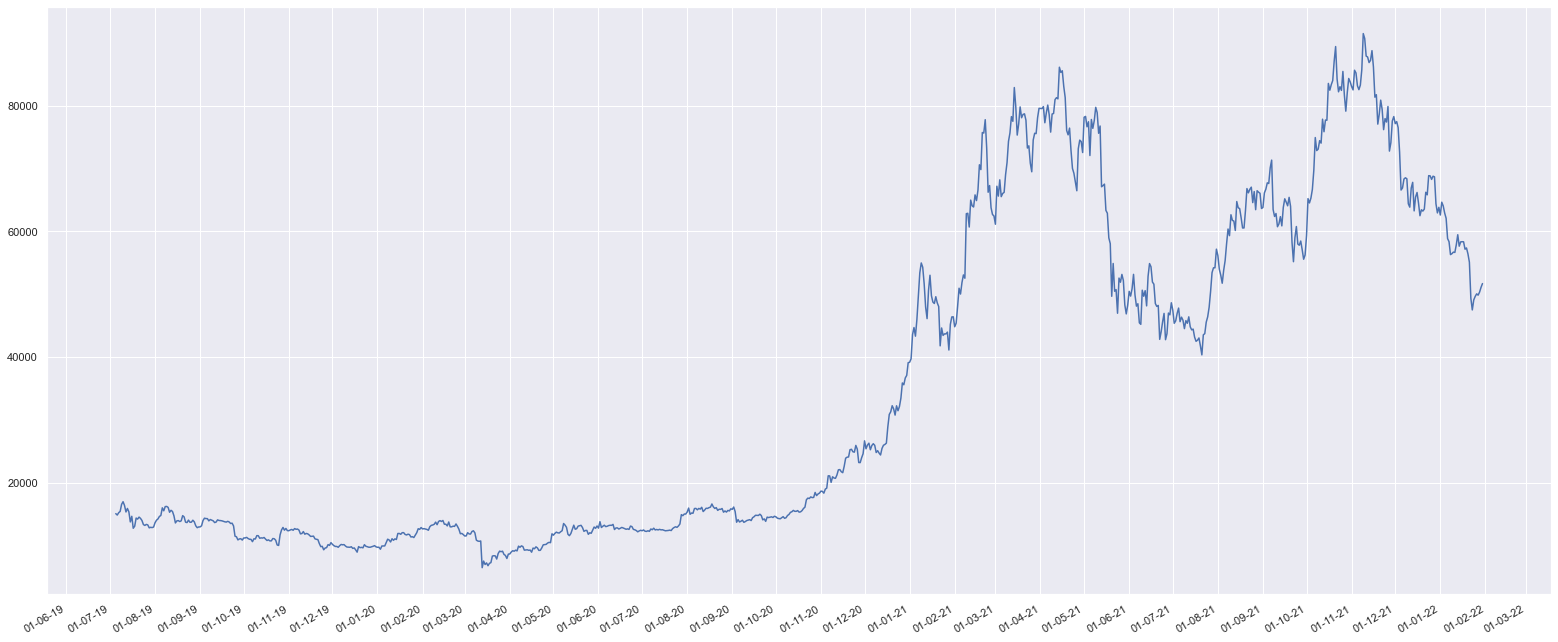

In [30]:
timeSeriesPlot(joint_df['Open (BTC)'])

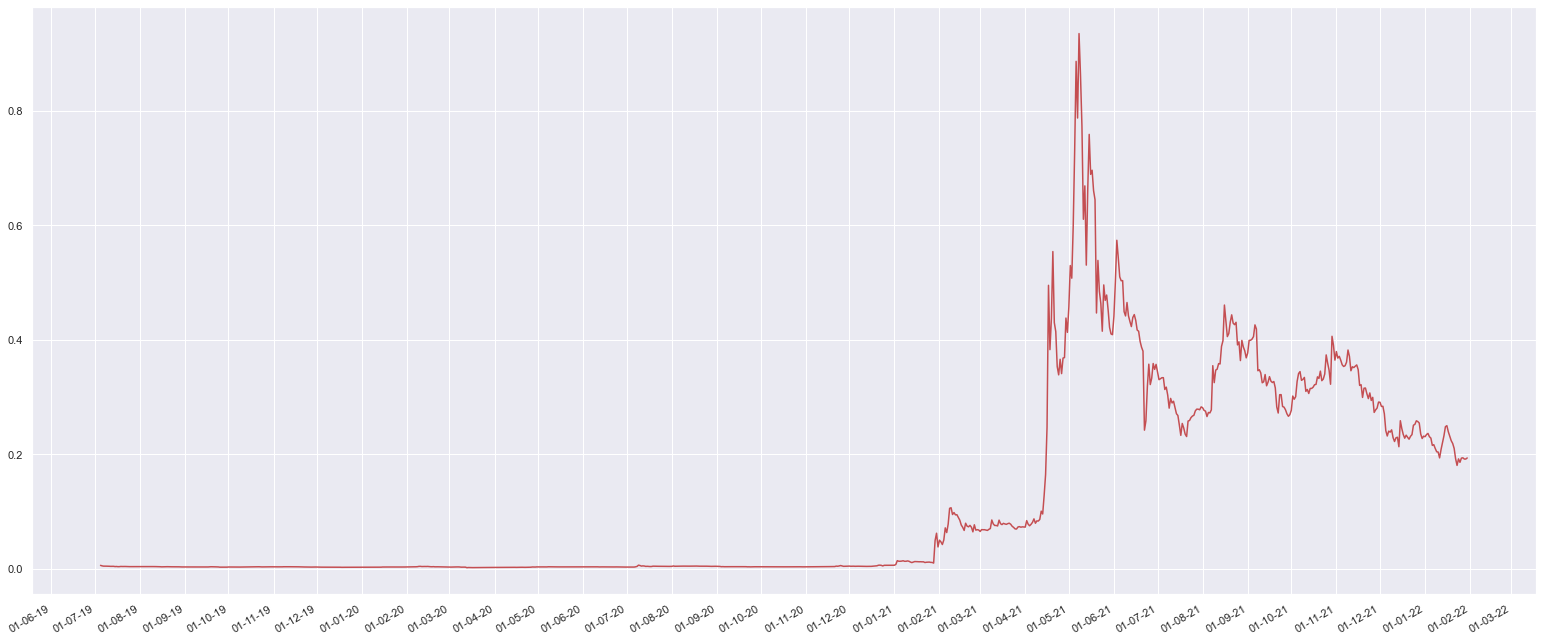

In [31]:
timeSeriesPlot(joint_df['Open (Doge)'], 'r')

For now, we can only plot them separately as the differences in **Bitcoin** and **Dogecoin** are `EXTREMELY LARGE`... <br>
In order to visualize both of them together, we first need to `normalize` them.

### Let's Normalize the Data!

We will normalize the data using the the `MinMaxScaler` function from `sklearn`!

In [32]:
joint_df2 = joint_df.drop(['Date'], axis=1)
joint_df2 = joint_df2.reset_index(drop=True)
joint_df2.head()

,Open (BTC),Open (Doge)
0,15099.039149,0.006083
1,14877.870827,0.005248
2,15249.112815,0.004747
3,15457.127000,0.004793
4,16579.631420,0.004690


In [33]:
# Data Prep
BTC_T = joint_df2.drop(['Open (Doge)'], axis=1)
Doge_T = joint_df2.drop(['Open (BTC)'], axis=1)
BTC_T = BTC_T.values
Doge_T = Doge_T.values

# Normalizing
scaler = MinMaxScaler(feature_range=(0,1))
BTC_T = scaler.fit_transform(BTC_T)
BTC_T = pd.DataFrame(BTC_T, columns=['BTC_Norm'])

Doge_T = scaler.fit_transform(Doge_T)
Doge_T = pd.DataFrame(Doge_T, columns=['Doge_Norm'])

In [34]:
joint_df2 = pd.concat([joint_df, BTC_T, Doge_T], axis=1)

In [35]:
joint_df2

,Date,Open (BTC),Open (Doge),BTC_Norm,Doge_Norm
0,2019-07-05,15099.039149,0.006083,0.101165,0.004348
1,2019-07-06,14877.870827,0.005248,0.098562,0.003453
2,2019-07-07,15249.112815,0.004747,0.102931,0.002916
3,2019-07-08,15457.127000,0.004793,0.105379,0.002965
4,2019-07-09,16579.631420,0.004690,0.118589,0.002855
...,...,...,...,...,...
936,2022-01-26,50067.436104,0.193316,0.512681,0.205140
937,2022-01-27,49862.768028,0.193858,0.510272,0.205722
938,2022-01-28,50340.801017,0.191690,0.515898,0.203397
939,2022-01-29,51094.637379,0.191690,0.524769,0.203397


Now that the data is normalized, we can plot them on the same graph!

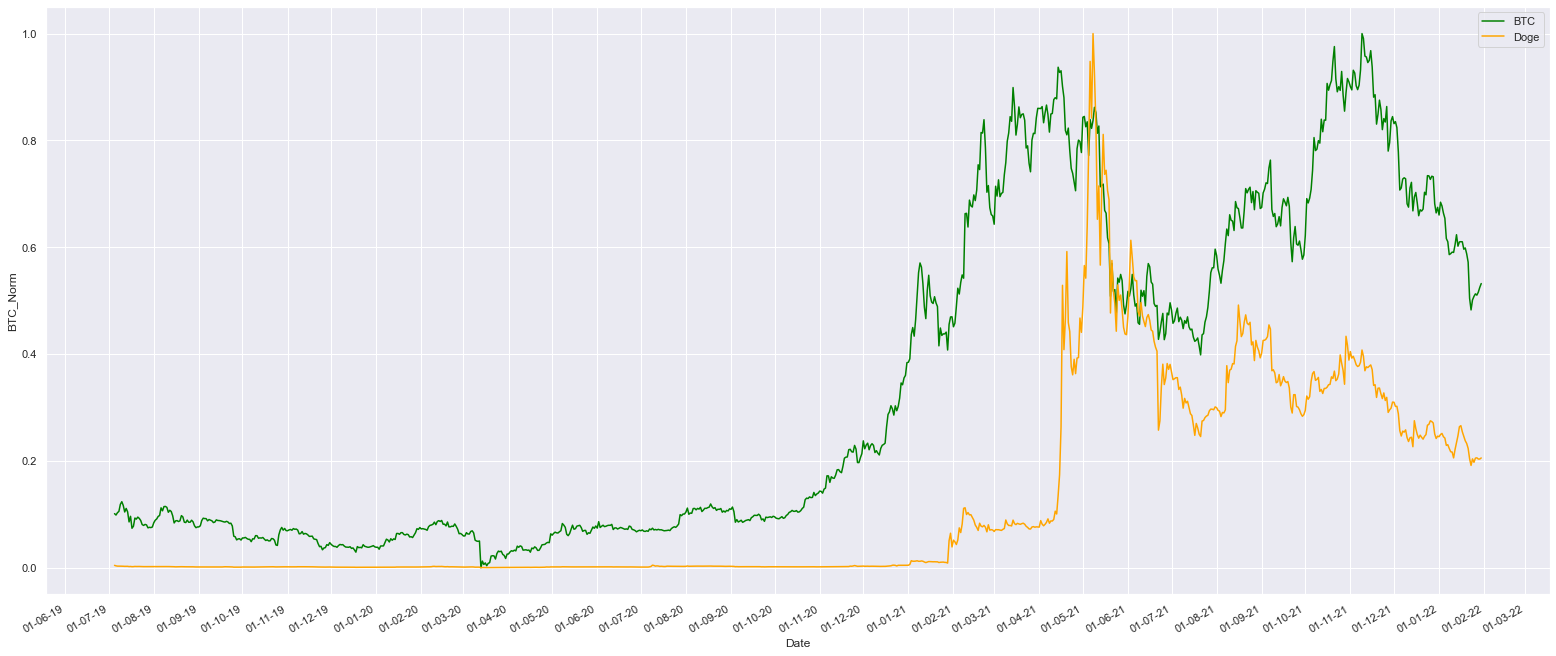

In [36]:
plt.figure(figsize=(24,12))
sb.lineplot(x=joint_df2['Date'], y=joint_df2['BTC_Norm'], color='green', label='BTC')
sb.lineplot(x=joint_df2['Date'], y=joint_df2['Doge_Norm'], color='orange', label='Doge')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y"))
plt.gcf().autofmt_xdate()
plt.show()

In [37]:
joint_df2.describe()

,Open (BTC),Open (Doge),BTC_Norm,Doge_Norm
count,941.000000,941.000000,941.000000,941.000000
mean,34865.589636,0.116179,0.333782,0.122418
std,26092.885578,0.170644,0.307067,0.183001
min,6502.573547,0.002028,0.000000,0.000000
25%,12620.331012,0.003435,0.071995,0.001509
50%,16248.502099,0.004437,0.114692,0.002583
75%,60549.603465,0.247233,0.636037,0.262963
max,91477.228354,0.934499,1.000000,1.000000


### We will use LSTM to predict for our model

We will try to predict Bitcoin first...

In [38]:
BTC = joint_df.drop(['Date', 'Open (Doge)'], axis=1)

In [39]:
scaler = MinMaxScaler(feature_range=(0,1))
BTC_T = BTC.values
BTC_T = scaler.fit_transform(BTC_T)

### Train/Test Split

We split our model into 80% train data and 20% test data

In [40]:
# 80 - 20 split
train_size = int(len(BTC_T) * 0.8)
test_size = int(len(BTC_T) - train_size)
train, test = BTC_T[0:train_size,:], BTC_T[train_size:len(BTC_T),:]

In [41]:
def create_features(data, look_back):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        window = data[i:(i + look_back), 0]
        X.append(window)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

Here, we reshape the train & test sets into the format that is accepted by the LSTM function.

In [42]:
look_back = 1
X_train, Y_train = create_features(train, look_back)
X_test, Y_test = create_features(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [43]:
# Import Essential Libs
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

In [44]:
# Set seed
tf.random.set_seed(11)
np.random.seed(11)

We set the parameters for the model. The dropout is used to reduce overfitting. Batch size is set to 30, to train based on the previous 30 days data as BTC runs 24/7.

In [45]:
# Build Model
model = Sequential()

model.add(LSTM(units = 2000, activation = 'relu', 
               input_shape = (X_train.shape[1], look_back)))

model.add(Dropout(0.2))

model.add(Dense(1, activation = 'linear'))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [46]:
filepath = 'saved_models_btc/model_epoch_{epoch:02d}.hdf5'

checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode ='min'
                            )

history = model.fit(X_train, Y_train, epochs = 100, batch_size = 24, validation_data = (X_test, Y_test), 
                    callbacks = [checkpoint], 
                    verbose = 1, shuffle = False)

model.summary()

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 0.0482
Epoch 00001: val_loss improved from inf to 0.12925, saving model to saved_models_btc\model_epoch_01.hdf5
32/32 [==============================] - 4s 84ms/step - loss: 0.0482 - val_loss: 0.1292
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 0.0400
Epoch 00002: val_loss improved from 0.12925 to 0.06575, saving model to saved_models_btc\model_epoch_02.hdf5
32/32 [==============================] - 3s 80ms/step - loss: 0.0400 - val_loss: 0.0658
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 0.0298
Epoch 00003: val_loss improved from 0.06575 to 0.03649, saving model to saved_models_btc\model_epoch_03.hdf5
32/32 [==============================] - 3s 80ms/step - loss: 0.0298 - val_loss: 0.0365
Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 0.0171
Epoch 00004: val_loss improved from 0.03649 to 0.01336, saving model to saved_models_btc\model_epoch_04.hdf5


Epoch 34/100
32/32 [==============================] - ETA: 0s - loss: 5.0483e-04
Epoch 00034: val_loss did not improve from 0.00078
32/32 [==============================] - 2s 76ms/step - loss: 5.0483e-04 - val_loss: 9.7000e-04
Epoch 35/100
32/32 [==============================] - ETA: 0s - loss: 5.5991e-04
Epoch 00035: val_loss did not improve from 0.00078
32/32 [==============================] - 3s 85ms/step - loss: 5.5991e-04 - val_loss: 8.2422e-04
Epoch 36/100
32/32 [==============================] - ETA: 0s - loss: 4.8544e-04
Epoch 00036: val_loss did not improve from 0.00078
32/32 [==============================] - 3s 79ms/step - loss: 4.8544e-04 - val_loss: 9.5433e-04
Epoch 37/100
32/32 [==============================] - ETA: 0s - loss: 5.4766e-04
Epoch 00037: val_loss did not improve from 0.00078
32/32 [==============================] - 2s 77ms/step - loss: 5.4766e-04 - val_loss: 8.2484e-04
Epoch 38/100
32/32 [==============================] - ETA: 0s - loss: 5.6042e-04
Epoch 0

Epoch 71/100
32/32 [==============================] - ETA: 0s - loss: 9.7252e-04
Epoch 00071: val_loss did not improve from 0.00078
32/32 [==============================] - 3s 82ms/step - loss: 9.7252e-04 - val_loss: 0.0013
Epoch 72/100
32/32 [==============================] - ETA: 0s - loss: 9.6099e-04
Epoch 00072: val_loss did not improve from 0.00078
32/32 [==============================] - 3s 80ms/step - loss: 9.6099e-04 - val_loss: 0.0019
Epoch 73/100
32/32 [==============================] - ETA: 0s - loss: 9.6919e-04
Epoch 00073: val_loss did not improve from 0.00078
32/32 [==============================] - 2s 78ms/step - loss: 9.6919e-04 - val_loss: 0.0013
Epoch 74/100
32/32 [==============================] - ETA: 0s - loss: 9.1643e-04
Epoch 00074: val_loss did not improve from 0.00078
32/32 [==============================] - 3s 88ms/step - loss: 9.1643e-04 - val_loss: 0.0016
Epoch 75/100
32/32 [==============================] - ETA: 0s - loss: 9.5088e-04
Epoch 00075: val_loss d

In [47]:
from keras.models import load_model

best_model = load_model('saved_models_btc\model_epoch_27.hdf5')
# Predicting and inverse transforming the predictions

train_predict = best_model.predict(X_train)

Y_hat_train = scaler.inverse_transform(train_predict)

test_predict = best_model.predict(X_test)

Y_hat_test = scaler.inverse_transform(test_predict)

# Inverse transforming the actual values, to return them to their original values
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

In [48]:
Y_hat_train = np.reshape(Y_hat_train, newshape = Y_hat_train.shape)
Y_hat_test = np.reshape(Y_hat_test, newshape = Y_hat_test.shape)

Y_train = np.reshape(Y_train, newshape = Y_hat_train.shape)
Y_test = np.reshape(Y_test, newshape = Y_hat_test.shape)

It can be expected that the RMSE of the train & test sets to be high as Cryptocurrencies are extremely volatile and unpredictable...

In [49]:
from sklearn.metrics import mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))

test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
1585.279242158054 

Test RMSE is: 
2394.7829811178667


In [50]:
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_hat_train, Y_hat_test)

In [51]:
result_df = pd.DataFrame()

result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat

result_df

,Actual_Y,Predicted_Y
0,14877.870827,15463.312500
1,15249.112815,15251.648438
2,15457.127000,15606.974609
3,16579.631420,15806.153320
4,16999.466497,16882.041016
...,...,...
932,49663.776145,48828.511719
933,50067.436104,49395.136719
934,49862.768028,49801.476562
935,50340.801017,49595.421875


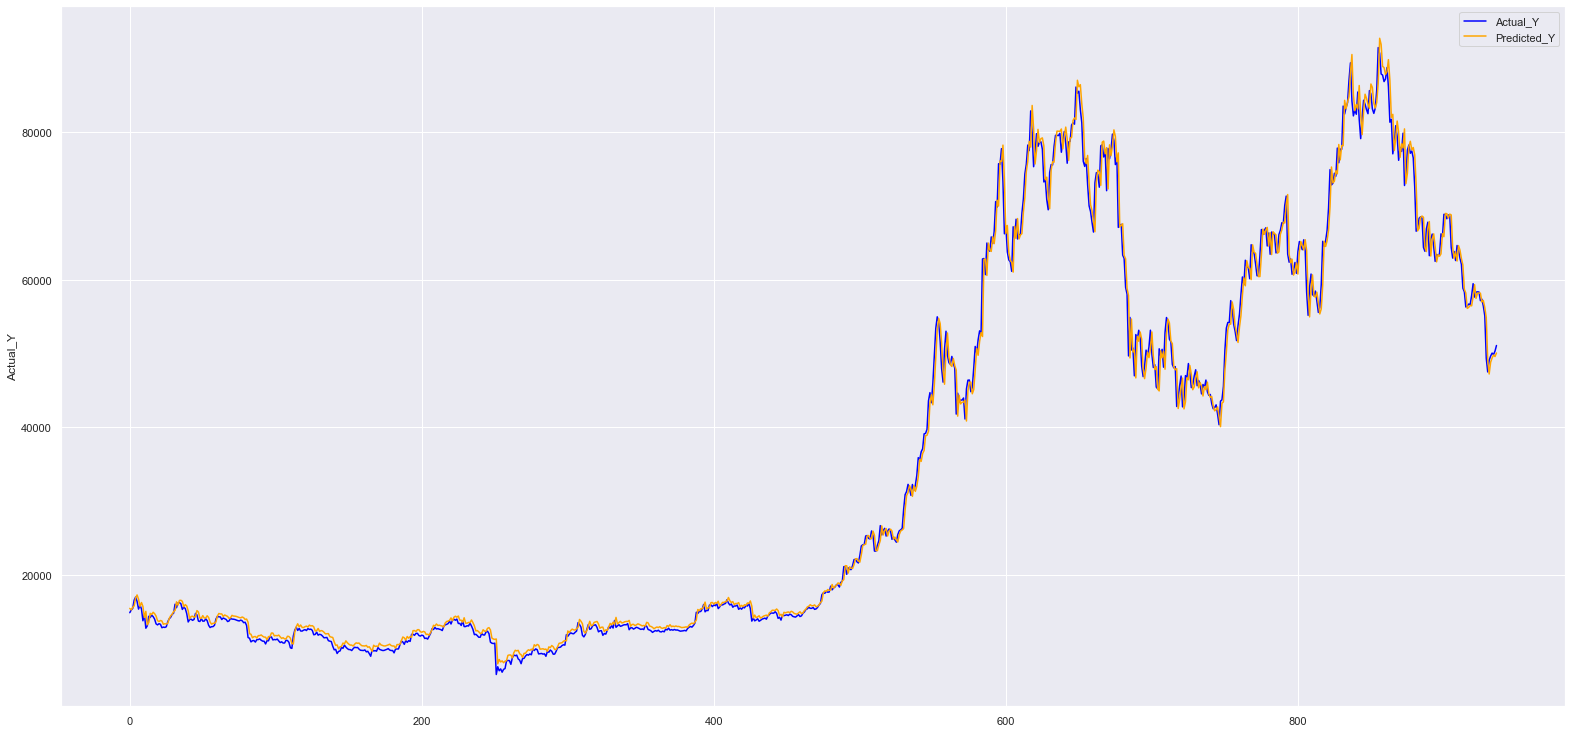

In [60]:
plt.figure(figsize=(24,12))
sb.lineplot(x=np.arange(0, len(result_df), 1), y=result_df['Actual_Y'], color='blue', label='Actual_Y')
sb.lineplot(x=np.arange(0, len(result_df), 1), y=result_df['Predicted_Y'], color='orange', label='Predicted_Y')

plt.show()